In [1]:
import os
import matplotlib.pyplot as plt
import wandb
import numpy as np

from ensemblecalibration.data import exp_gp, exp_dirichlet
from ensemblecalibration.data.dataset import MLPDataset
from ensemblecalibration.meta_model.losses import SKCELoss, LpLoss, MMDLoss, BrierLoss
from ensemblecalibration.utils.helpers import calculate_pbar
from ensemblecalibration.cal_estimates import mmd_kce
from ensemblecalibration.meta_model.train import get_optim_lambda_mlp
from ensemblecalibration.config.config_cal_test import config_binary_classification_mlp
from ensemblecalibration.cal_estimates import mmd_kce_obj, skce_obj, ece_kde_obj



TypeError: __init__() got an unexpected keyword argument 'bw'

In [ ]:
# HYPERPARAMETERS
N_TRAIN = 1000
N_VAL = 1000
X_BOUND = [0, 5]
LIST_BOUNDS_P = [[0.4, 0.6], [.8, 1.0]]
DEG = 2
BATCH_SIZE = 256
LR = 1e-4
LOSS_LP = LpLoss(p=2, bw=.1, lambda_bce=.1)
LOSS_SKCE= SKCELoss(bw=.01, lambda_bce=1e-3, use_square=True)
LOSS_MMD = MMDLoss(bw=0.01, lambda_bce=.00)
LOSS_BRIER = BrierLoss()

N_EPOCHS = 300
LR_SCHEDULER = True

1. $H_0$ hypothesis is true: non-instance dependent convex combination

In [ ]:
# sample data from GP experiment
x_inst, p_preds, p_bar, y_labels, weights_l = exp_gp(n_samples = N_TRAIN, x_bound = X_BOUND,
                                          bounds_p=LIST_BOUNDS_P, x_dep=True, deg=2)

# sample data from Dirichlet experiment
x_inst_dir, p_preds_dir, p_bar_dir, y_labels_dir, weights_l_dir = exp_dirichlet(n_samples=N_TRAIN,
                                                                                n_members=5,
                                                                                n_classes=3,
                                                                                x_bound=X_BOUND,
                                                                                h0=True,
                                                                                x_dep=True,
)

Setting:

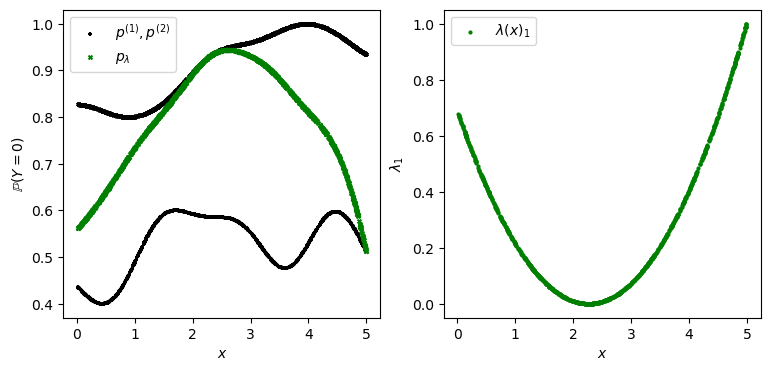

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))

ax[0].scatter(x_inst.squeeze(), p_preds[:, 0, 0], label="$p^{(1)}, p^{(2)}$", color='black', marker='+', s=5)
ax[0].scatter(x_inst.squeeze(), p_preds[:, 1, 0],  color='black', marker='x', s=5)
# shade space between p_preds[:,0,0] and p_preds[:,1,0]
#ax[0].fill_between(x, p_preds[:, 0, 0], p_preds[:, 1, 0], color='black', alpha=0.2)
ax[0].scatter(x_inst.squeeze(), p_bar[:, 0], label="$p_{\lambda}$", color='green', marker='x', s=8)
# x and y axis labels
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$\mathbb{P}(Y=0)$")
ax[0].legend()

ax[1].scatter(x_inst.squeeze(), weights_l[:, 0], s=4, c="green", label=r"$\lambda(x)_1$")
ax[1].set_xlabel("$x$")
ax[1].set_ylabel("$\lambda_1$")
ax[1].legend()

look at losses on "true" underlying convex combination:

In [2]:
print(LOSS_MMD(p_preds, weights_l, y_labels))
print(LOSS_LP(p_preds, weights_l, y_labels))
print(LOSS_SKCE(p_preds, weights_l, y_labels))
print(LOSS_BRIER(p_preds, weights_l, y_labels))

NameError: name 'LOSS_MMD' is not defined

In [87]:
dataset_train = MLPDataset(x_train=x_inst, P=p_preds, y=y_labels)

### Brier Score

analyse the training with brier score as a loss function:

In [35]:
pred_lambda_brier, loss = get_optim_lambda_mlp(dataset_train,
                                               LOSS_BRIER,
                                               n_epochs=N_EPOCHS,
                                               lr=LR,
                                               batch_size=BATCH_SIZE,
                                               hidden_dim=64,
                                               hidden_layers=3)

Text(0.5, 0, '$x$')

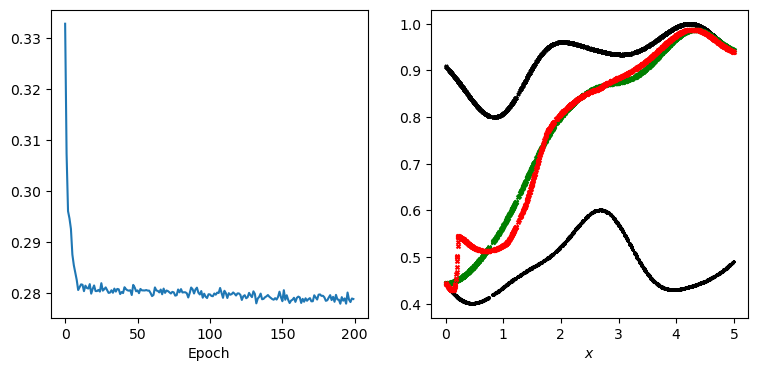

In [36]:
# plot results
# calculate pbar with learned weights
p_bar_pred_brier = calculate_pbar(pred_lambda_brier, p_preds)

fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].plot(loss)
ax[0].set_xlabel("Epoch")

ax[1].scatter(x_inst.squeeze(), p_preds[:, 0, 0], label="$p^{(1)}, p^{(2)}$", color='black', marker='+', s=5)
ax[1].scatter(x_inst.squeeze(), p_preds[:, 1, 0],  color='black', marker='x', s=5)
# shade space between p_preds[:,0,0] and p_preds[:,1,0]
#ax[0].fill_between(x, p_preds[:, 0, 0], p_preds[:, 1, 0], color='black', alpha=0.2)
ax[1].scatter(x_inst.squeeze(), p_bar[:, 0], label="$p_{\lambda}$", color='green', marker='x', s=8)
ax[1].scatter(x_inst.squeeze(), p_bar_pred_brier[:, 0], label="$p_{\lambda}$", color='red', marker='x', s=8)
# x and y axis labels
ax[1].set_xlabel("$x$")

### 1. Squared-Kernel Calibration Error

use squared KCE of Widmann et al for training:

In [89]:
pred_lambda_skce, loss_skce = get_optim_lambda_mlp(dataset_train,
                                               LOSS_SKCE,
                                               n_epochs=N_EPOCHS,
                                               lr=1e-4,
                                               batch_size=512,
                                               hidden_dim=64,
                                               hidden_layers=3)

plot results:

Text(0.5, 0, '$x$')

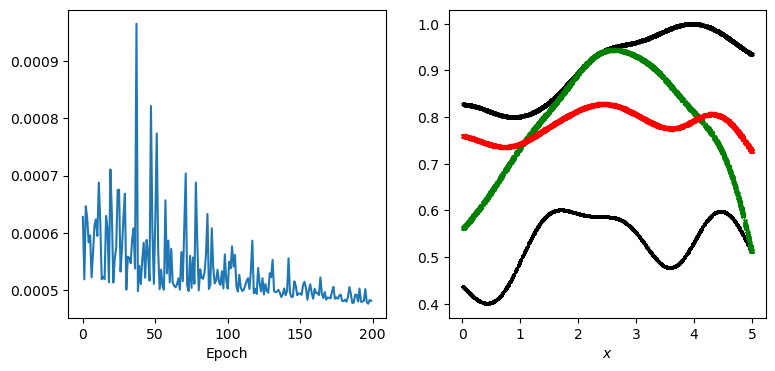

In [91]:
# plot results
# calculate pbar with learned weights
p_bar_pred_skce = calculate_pbar(pred_lambda_skce, p_preds)

fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].plot(loss_skce)
ax[0].set_xlabel("Epoch")

ax[1].scatter(x_inst.squeeze(), p_preds[:, 0, 0], label="$p^{(1)}, p^{(2)}$", color='black', marker='+', s=5)
ax[1].scatter(x_inst.squeeze(), p_preds[:, 1, 0],  color='black', marker='x', s=5)
# shade space between p_preds[:,0,0] and p_preds[:,1,0]
#ax[0].fill_between(x, p_preds[:, 0, 0], p_preds[:, 1, 0], color='black', alpha=0.2)
ax[1].scatter(x_inst.squeeze(), p_bar[:, 0], label="$p_{\lambda}$", color='green', marker='x', s=8)
ax[1].scatter(x_inst.squeeze(), p_bar_pred_skce[:, 0], label="$p_{\lambda}$", color='red', marker='x', s=8)
# x and y axis labels
ax[1].set_xlabel("$x$")

### MMD calibration error
We perform an analysis over the badnwidth to see when the model "over" and "underfits".

In [20]:
pred_lambdas_mmd_reg = []
losses_mmd_reg = []
list_bw = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]

for bw in list_bw:
    loss_mmd = MMDLoss(bw=bw, lambda_bce=0.00)
    pred_lambda_mmd, loss = get_optim_lambda_mlp(
        dataset_train=dataset_train,
        loss=loss_mmd,
        n_epochs=300,
        lr=1e-4,
        hidden_dim=64,
        hidden_layers=3,
        batch_size=64,
        patience=200,
    )
    pred_lambdas_mmd_reg.append(pred_lambda_mmd)
    losses_mmd_reg.append(loss)

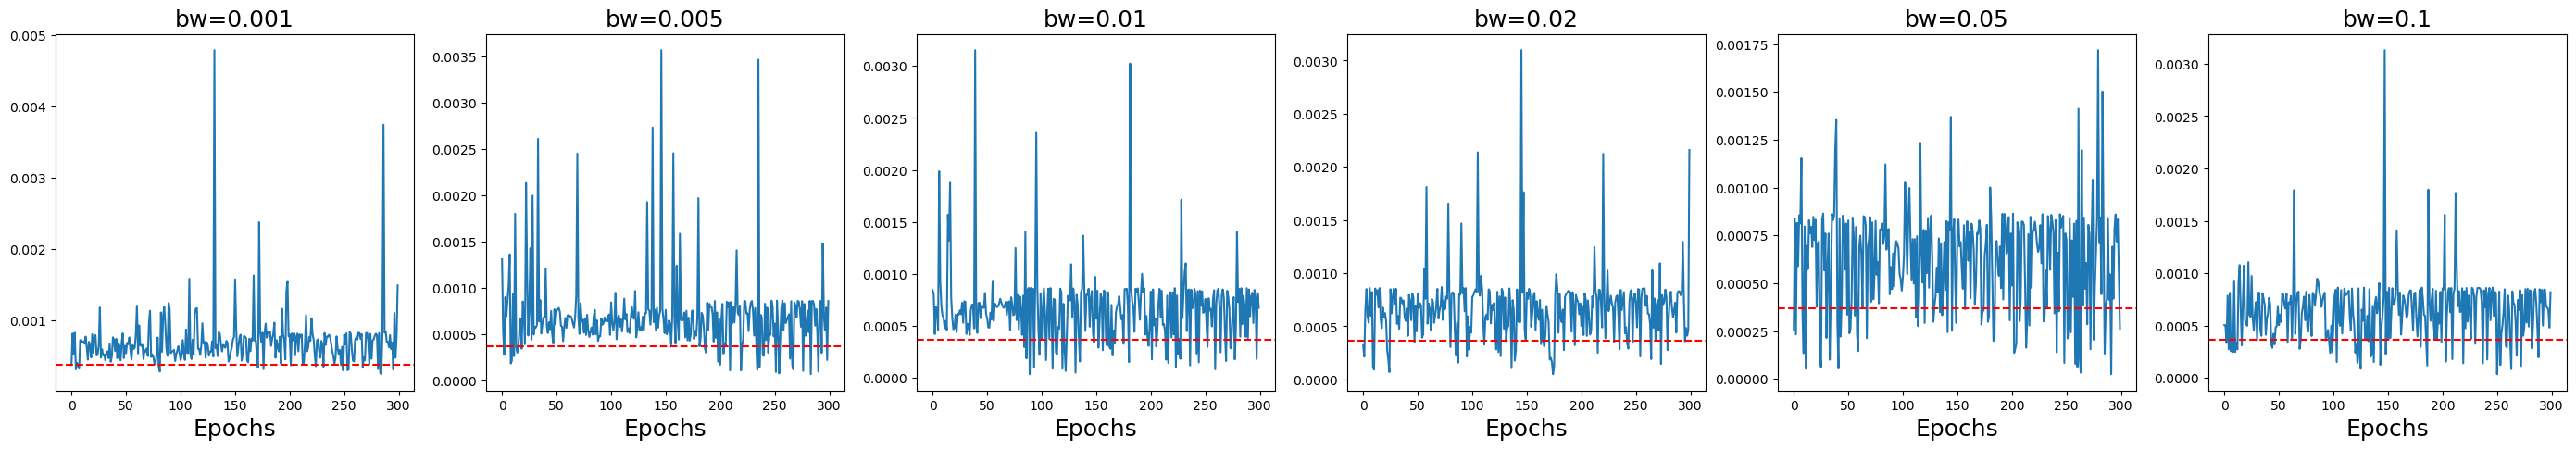

In [16]:
fig, ax = plt.subplots(1, len(losses_mmd_reg), figsize=(35,5))

for i, loss in enumerate(losses_mmd_reg):
    loss_mmd = MMDLoss(bw=list_bw[i], lambda_bce=0.001)
    ax[i].plot(loss)
    ax[i].axhline(y=LOSS_MMD(p_preds, weights_l, y_labels), color='r', linestyle='--')
    ax[i].set_title(f"bw={list_bw[i]}", fontsize=18)
    ax[i].set_xlabel("Epochs", fontsize=18)

plt.savefig("../figures/mmd_loss_bw_reg.png", dpi=400)


In [17]:
loss_mmd_unreg = MMDLoss(bw=.05, lambda_bce=0)

# compare loss on real and predicted convex combination
print(loss_mmd_unreg(p_preds, weights_l, y_labels))
print(loss_mmd_unreg(p_preds, pred_lambda_mmd, y_labels))

tensor(0.0004)
tensor(0.0004)


In [18]:
# calculate predicted pbar
p_bar_pred_mmd = calculate_pbar(pred_lambdas_mmd_reg[1], p_preds, ).detach().numpy()


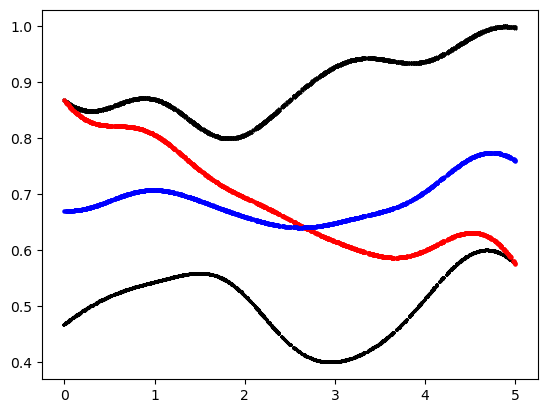

In [19]:
#plot data
plt.scatter(x_inst.squeeze(), p_preds[:, 0, 0], label="$\hat{p}^{(1)}, \hat{p}^{(2)}$", color='black', marker='+', s=5)
plt.scatter(x_inst.squeeze(), p_preds[:, 1, 0],  color='black', marker='x', s=5)
#plt.fill_between(x_inst.squeeze(), p_preds[:, 0, 0], p_preds[:, 1, 0], color='black', alpha=0.2)
plt.scatter(x_inst.squeeze(), p_bar[:,0], label="$\bar{p}_{\lambda}$", color='red', s=5)
plt.scatter(x_inst.squeeze(), p_bar_pred_mmd[:,0], label="$\bar{p}_{\lambda}^{pred}$", color='blue', s=5)

### $L^p$ calibration error

see Popordanoska et al.

In [69]:
pred_lambda_lp, loss_lp = get_optim_lambda_mlp(dataset_train,
                                               LOSS_LP,
                                               n_epochs=N_EPOCHS,
                                               lr=LR,
                                               batch_size=BATCH_SIZE,
                                               hidden_dim=64,
                                               hidden_layers=3)

Text(0.5, 0, '$x$')

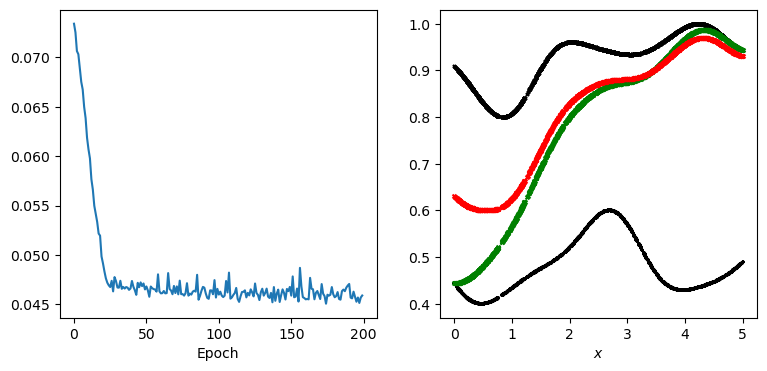

In [70]:
p_bar_pred_lp = calculate_pbar(pred_lambda_lp, p_preds)

fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].plot(loss_lp)
ax[0].set_xlabel("Epoch")

ax[1].scatter(x_inst.squeeze(), p_preds[:, 0, 0], label="$p^{(1)}, p^{(2)}$", color='black', marker='+', s=5)
ax[1].scatter(x_inst.squeeze(), p_preds[:, 1, 0],  color='black', marker='x', s=5)
# shade space between p_preds[:,0,0] and p_preds[:,1,0]
#ax[0].fill_between(x, p_preds[:, 0, 0], p_preds[:, 1, 0], color='black', alpha=0.2)
ax[1].scatter(x_inst.squeeze(), p_bar[:, 0], label="$p_{\lambda}$", color='green', marker='x', s=8)
ax[1].scatter(x_inst.squeeze(), p_bar_pred_lp[:, 0], label="$p_{\lambda}$", color='red', marker='x', s=8)
# x and y axis labels
ax[1].set_xlabel("$x$")

In [ ]:
def forward(self, x, return_feature = False):
        for i, l in enumerate(self.predictor[:-2]):
            x = l(x) # outputs last hidden states
        x_scores = self.predictor[-2](x) # in the k-dimensional space
        x_scores = self.predictor[-1](x_scores)
        if return_feature:
            return x_scores, x